# Data analysis

### Import of libraries

In [41]:
import pandas as pd
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os, re, sys, glob, math
import warnings; warnings.simplefilter('ignore')
import statsmodels.api as sm # import statsmodels
import lzma 
import base64
from statistics import mean, median
from matplotlib.ticker import PercentFormatter
from datetime import datetime

### Import of data

In [42]:
subfolder = 'Pilot-6Stages'
outputpath = f'../output/{subfolder}/'
outputpathErrors = f'../output/{subfolder}/errors/'

### Cleaning data

In [43]:
def merge_all_files(keyword,subfolder='main'):
    all_files = glob.glob(os.path.join(r'../data/'+subfolder+'/', keyword + '*.csv'))
    return pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True, sort=True)

data = merge_all_files('inference',subfolder=subfolder)
sessions = ['0ek36qyn', 'dnzri4y1'] 
taskDifficultyValues = [1,2]
# Only keep those in-session who finished 
data = data[data['session.code'].isin(sessions) & data['inference.1.player.taskDifficulty'].isin(taskDifficultyValues)]
print(len(data))

40


In [44]:
# launchDate1 = datetime.strptime('22/07/07 13:00:00', '%y/%m/%d %H:%M:%S')
# # endDate1 = datetime.strptime('22/05/18 16:00:00', '%y/%m/%d %H:%M:%S')
# # launchDate2 = datetime.strptime('22/05/19 13:00:00', '%y/%m/%d %H:%M:%S')
# # print('The end date 1 is:', endDate1)

# dt_obj = []
# for ind in data.index:
#     date_str = data['participant.time_started_utc'][ind].replace('-','/')[2:19]
#     dt_obj.append(datetime.strptime(date_str, '%y/%m/%d %H:%M:%S'))
# data['time_started'] = dt_obj 
# # data = data[((data['time_started']>launchDate1) & (data['time_started']<endDate1))]
# data = data[data['time_started']>launchDate1]
# print(len(data))

### Errors

inference.1.player.cq10_mistakes


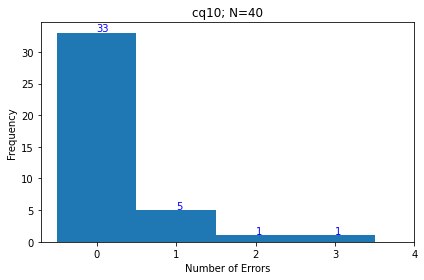

inference.1.player.cq1_mistakes


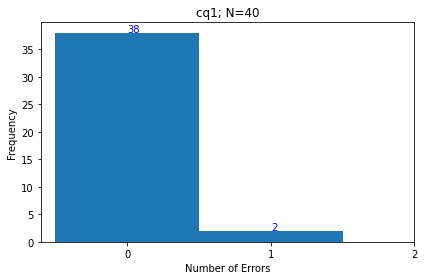

inference.1.player.cq2_mistakes


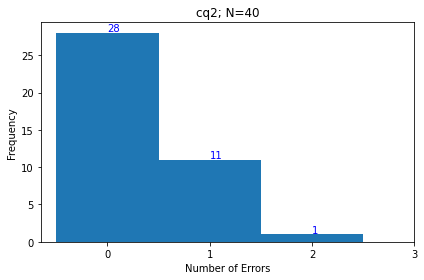

inference.1.player.cq3_mistakes


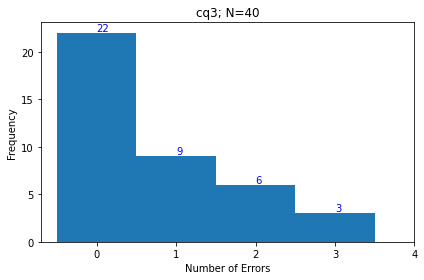

inference.1.player.cq4_mistakes


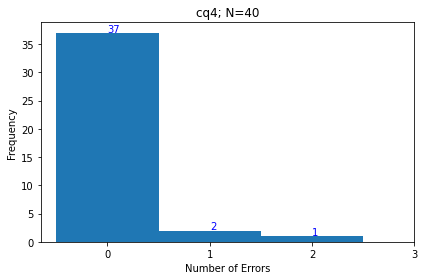

inference.1.player.cq5_mistakes


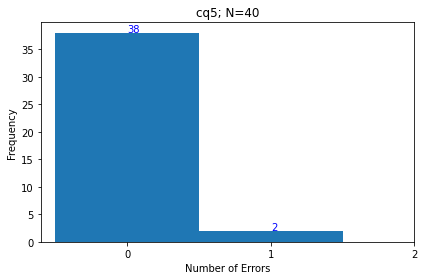

inference.1.player.cq5_stage2_mistakes


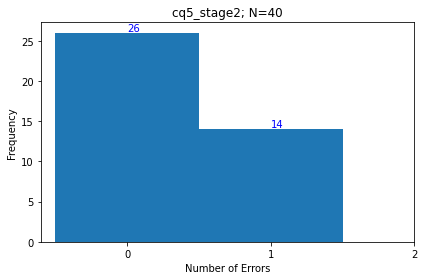

inference.1.player.cq6_mistakes


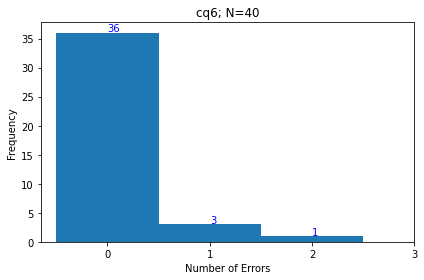

inference.1.player.cq7_mistakes


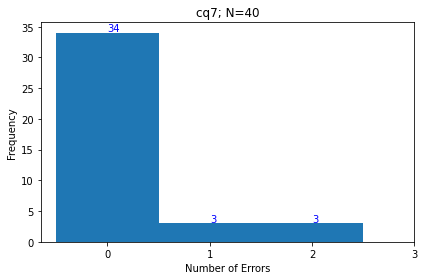

inference.1.player.cq8_mistakes


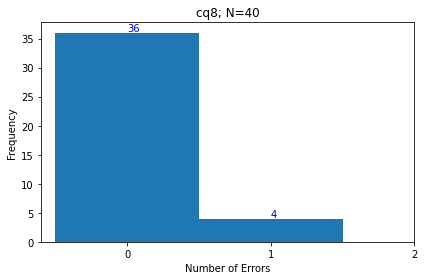

inference.1.player.cq8_naive_mistakes


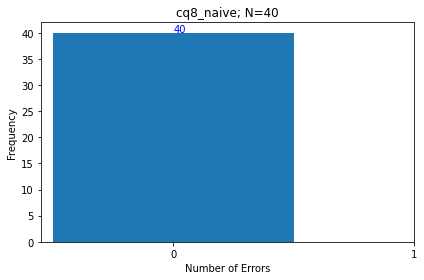

inference.1.player.cq9_mistakes


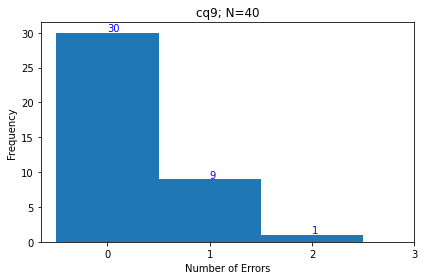

inference.1.player.cq9_soph_mistakes
Variable missing: inference.1.player.cq9_soph_mistakes
inference.1.player.cq_stage2_mistakes


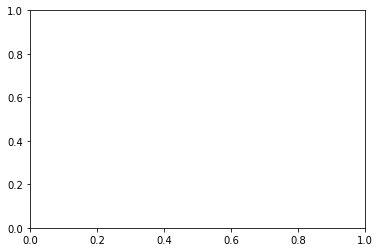

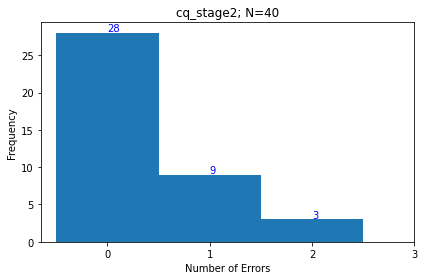

In [45]:
col_list = []
col_list_names = []
for col in data.columns.values:
    if col.endswith('_mistakes'):
        col_list.append(data[col])
        col_list_names.append(col)

for var in col_list:
    try:
        print(var.name)
        fig, ax = plt.subplots()
        y = [int(i) for i in  var]
        xLabels = range(max(y)+2)
        x = np.arange(max(y)+2)
        ax.hist(y,x-0.5, width=1)
        plt.ylabel('Frequency')
        for i in range(max(y)+1):
            plt.text(i,y.count(i)+.2,y.count(i), color='blue')
        plt.xticks(x, xLabels)
        plt.xlabel('Number of Errors')
        plt.title(f"{var.name[19:-9]}; N={len(var)}")
        plt.tight_layout()
        plt.savefig(outputpathErrors+ var.name[19:-9] +'.png',dpi=1000)
        plt.show()
    except:
        print('Variable missing:', var.name)

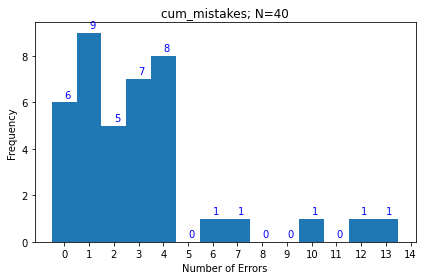

In [46]:
data['cum_mistakes']=data[col_list_names].sum(axis=1)

var = data['cum_mistakes']
fig, ax = plt.subplots()
y = [int(i) for i in  var]
xLabels = range(max(y)+2)
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+1):
    plt.text(i,y.count(i)+.2,y.count(i), color='blue')
plt.xticks(x, xLabels)
plt.xlabel('Number of Errors')
plt.title(f"{var.name}; N={len(var)}")
plt.tight_layout()
plt.savefig(outputpathErrors+ var.name +'.png',dpi=1000)
plt.show()

##### Only keep people with 4 or less CQ mistakes


In [47]:
print(len(data), 'before dropping')
data = data[data['cum_mistakes']<5]
print(len(data), 'after dropping')

40 before dropping
35 after dropping


## Treatments

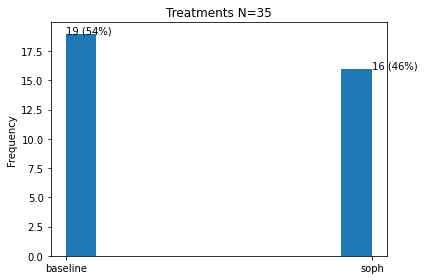

In [48]:
fig, ax = plt.subplots()
y = [i for i in  data['inference.1.player.treatment']]
# Labels = ['naive', 'baseline', 'soph']
Labels = ['baseline', 'soph']
ax.hist(y)
plt.ylabel('Frequency')
for j in range(2):
    plt.text(j,y.count(Labels[j]),str(y.count(Labels[j]))+ ' (' + str(round(y.count(Labels[j])*100/len(y))) +'%)')
plt.title(f'Treatments N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + 'treatments.png',dpi=1000)
plt.show()

### Reverse taskDifficulty in probabilistic to get at what they chose

In [49]:
for s in ['','2','_stage2','2_stage2']:
    print(f'Task Difficulty{s}')
    data[f'observedTaskDifficulty{s}'] = data[f'inference.1.player.taskDifficulty{s}']
    for ind in data.index:
        print('Pre-switch:', data[f'inference.1.player.probabilistic{s}'][ind], data[f'inference.1.player.taskDifficulty{s}'][ind])
        if data[f'inference.1.player.probabilistic{s}'][ind] <0.25:
            if data[f'inference.1.player.taskDifficulty{s}'][ind] == 2:
                data[f'inference.1.player.taskDifficulty{s}'][ind] = 1
            elif data[f'inference.1.player.taskDifficulty{s}'][ind] == 1:
                data[f'inference.1.player.taskDifficulty{s}'][ind] = 2
        print(ind, 'Post-switch:', data[f'inference.1.player.probabilistic{s}'][ind], data[f'inference.1.player.taskDifficulty{s}'][ind])

    print('Number of people switched: ', len(data[data[f'inference.1.player.probabilistic{s}']<0.25]))

Task Difficulty
Pre-switch: 0.938347122 2.0
4 Post-switch: 0.938347122 2.0
Pre-switch: 0.723988645 1.0
7 Post-switch: 0.723988645 1.0
Pre-switch: 0.96655953 1.0
8 Post-switch: 0.96655953 1.0
Pre-switch: 0.043380406 1.0
9 Post-switch: 0.043380406 2.0
Pre-switch: 0.239177303 1.0
10 Post-switch: 0.239177303 2.0
Pre-switch: 0.336901504 2.0
12 Post-switch: 0.336901504 2.0
Pre-switch: 0.204756795 2.0
13 Post-switch: 0.204756795 1.0
Pre-switch: 0.183751059 2.0
15 Post-switch: 0.183751059 1.0
Pre-switch: 0.305432817 1.0
16 Post-switch: 0.305432817 1.0
Pre-switch: 0.766211658 2.0
17 Post-switch: 0.766211658 2.0
Pre-switch: 0.014787391 1.0
18 Post-switch: 0.014787391 2.0
Pre-switch: 0.945213009 2.0
19 Post-switch: 0.945213009 2.0
Pre-switch: 0.936291998 2.0
21 Post-switch: 0.936291998 2.0
Pre-switch: 0.855501514 2.0
22 Post-switch: 0.855501514 2.0
Pre-switch: 0.196558944 2.0
23 Post-switch: 0.196558944 1.0
Pre-switch: 0.577088136 2.0
24 Post-switch: 0.577088136 2.0
Pre-switch: 0.494203872 2.0
25

61 Post-switch: 0.2975280286234393 1.0
Pre-switch: 0.3232968251928477 2.0
62 Post-switch: 0.3232968251928477 2.0
Pre-switch: 0.8415791723698429 2.0
64 Post-switch: 0.8415791723698429 2.0
Pre-switch: 0.1612058738578096 2.0
65 Post-switch: 0.1612058738578096 1.0
Pre-switch: 0.3995561244495355 2.0
66 Post-switch: 0.3995561244495355 2.0
Pre-switch: 0.2240662222276164 1.0
67 Post-switch: 0.2240662222276164 2.0
Number of people switched:  13


## Sophisticated

In [50]:
soph = data[data['inference.1.player.soph']==1]
print(len(soph))

16


### Part 1: Task Difficulty

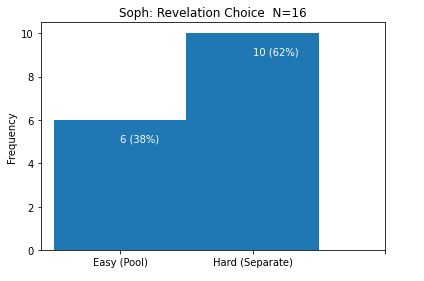

    inference.1.player.taskDifficulty  observedTaskDifficulty
9                                 2.0                     1.0
13                                1.0                     2.0
16                                1.0                     1.0
17                                2.0                     2.0
23                                1.0                     2.0
24                                2.0                     2.0
25                                2.0                     2.0
45                                1.0                     2.0
49                                1.0                     1.0
51                                1.0                     1.0
53                                2.0                     2.0
54                                2.0                     2.0
55                                2.0                     2.0
57                                2.0                     2.0
60                                2.0                     2.0
62      

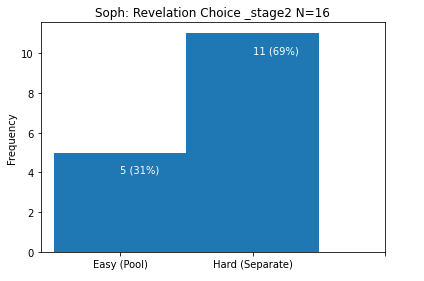

    inference.1.player.taskDifficulty_stage2  observedTaskDifficulty_stage2
9                                        2.0                            2.0
13                                       2.0                            2.0
16                                       1.0                            1.0
17                                       2.0                            2.0
23                                       1.0                            1.0
24                                       2.0                            2.0
25                                       2.0                            2.0
45                                       1.0                            1.0
49                                       2.0                            2.0
51                                       1.0                            1.0
53                                       2.0                            1.0
54                                       2.0                            2.0
55          

In [51]:
for s in ['','_stage2']:
    fig, ax = plt.subplots()
    y = [int(i)-1 for i in  soph[f'inference.1.player.taskDifficulty{s}']]
    xLabels = ['Easy (Pool)', 'Hard (Separate)', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for i in range(max(y)+2):
        plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Soph: Revelation Choice {s} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'Soph_taskDifficulty{s}.png',dpi=1000)
    plt.show()
    print(soph[[f'inference.1.player.taskDifficulty{s}', f'observedTaskDifficulty{s}']])

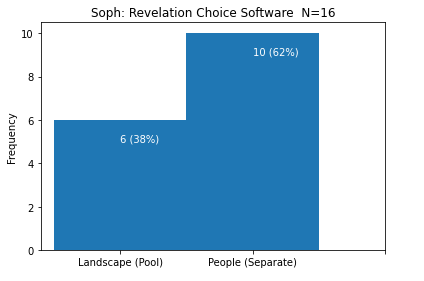

9     1.0
13    1.0
16    1.0
17    2.0
23    1.0
24    2.0
25    2.0
45    2.0
49    1.0
51    1.0
53    2.0
54    2.0
55    2.0
57    2.0
60    2.0
62    2.0
Name: inference.1.player.taskDifficulty2, dtype: float64


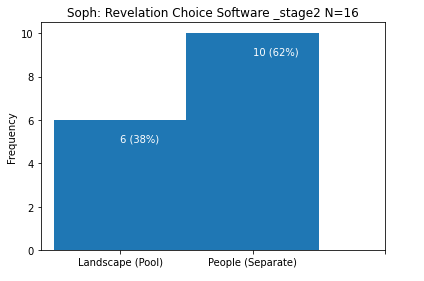

9     2.0
13    2.0
16    1.0
17    2.0
23    1.0
24    1.0
25    2.0
45    1.0
49    1.0
51    2.0
53    1.0
54    2.0
55    2.0
57    2.0
60    2.0
62    2.0
Name: inference.1.player.taskDifficulty2_stage2, dtype: float64


In [52]:
for s in ['','_stage2']:
    fig, ax = plt.subplots()
    y = [int(i)-1 for i in  soph[f'inference.1.player.taskDifficulty2{s}']]
    xLabels = ['Landscape (Pool)', 'People (Separate)', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for i in range(max(y)+2):
        plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Soph: Revelation Choice Software {s} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'Soph_taskDifficulty2{s}.png',dpi=1000)
    plt.show()
    print(soph[f'inference.1.player.taskDifficulty2{s}'])

## Baseline

In [53]:
base = data[data['inference.1.player.baseline']==1]
print(len(base))

19


### Part 1: Task Difficulty

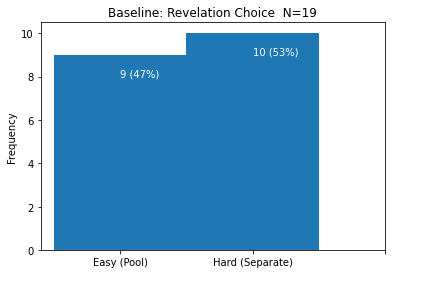

4     2.0
7     1.0
8     1.0
10    2.0
12    2.0
15    1.0
18    2.0
19    2.0
21    2.0
22    2.0
46    1.0
48    1.0
50    1.0
52    1.0
61    2.0
64    2.0
65    1.0
66    2.0
67    1.0
Name: inference.1.player.taskDifficulty, dtype: float64


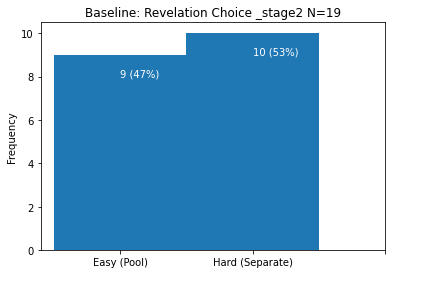

4     2.0
7     1.0
8     2.0
10    2.0
12    2.0
15    1.0
18    1.0
19    2.0
21    2.0
22    1.0
46    1.0
48    1.0
50    2.0
52    1.0
61    1.0
64    2.0
65    1.0
66    2.0
67    2.0
Name: inference.1.player.taskDifficulty_stage2, dtype: float64


In [54]:
for s in ['','_stage2']:
    fig, ax = plt.subplots()
    y = [int(i)-1 for i in  base[f'inference.1.player.taskDifficulty{s}']]
    xLabels = ['Easy (Pool)', 'Hard (Separate)', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for i in range(max(y)+2):
        plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Baseline: Revelation Choice {s} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath +  f'Baseline_taskDifficulty{s}.png',dpi=1000)
    plt.show()
    print(base[f'inference.1.player.taskDifficulty{s}'])

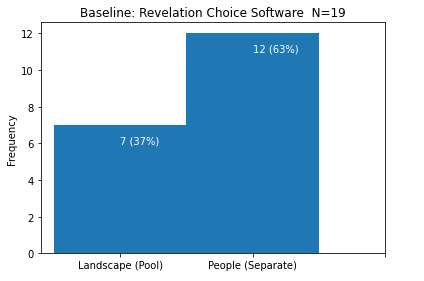

4     2.0
7     1.0
8     1.0
10    2.0
12    2.0
15    1.0
18    2.0
19    2.0
21    2.0
22    2.0
46    1.0
48    1.0
50    1.0
52    1.0
61    2.0
64    2.0
65    1.0
66    2.0
67    1.0
Name: inference.1.player.taskDifficulty, dtype: float64


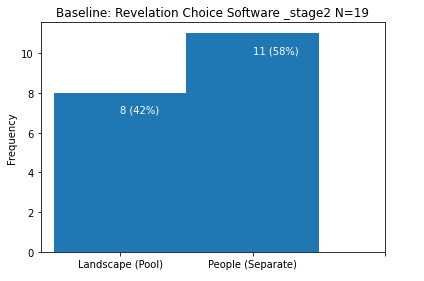

4     2.0
7     1.0
8     2.0
10    2.0
12    2.0
15    1.0
18    1.0
19    2.0
21    2.0
22    1.0
46    1.0
48    1.0
50    2.0
52    1.0
61    1.0
64    2.0
65    1.0
66    2.0
67    2.0
Name: inference.1.player.taskDifficulty_stage2, dtype: float64


In [55]:
for s in ['','_stage2']:
    fig, ax = plt.subplots()
    y = [int(i)-1 for i in  base[f'inference.1.player.taskDifficulty2{s}']]
    xLabels = ['Landscape (Pool)', 'People (Separate)', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for i in range(max(y)+2):
        plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Baseline: Revelation Choice Software {s} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'Baseline_taskDifficulty2{s}.png',dpi=1000)
    plt.show()
    print(base[f'inference.1.player.taskDifficulty{s}'])

### Lottery

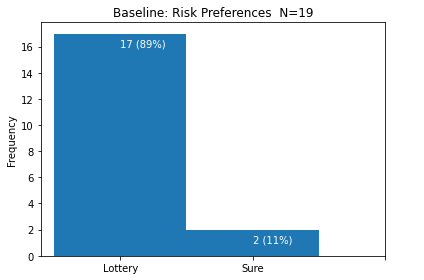

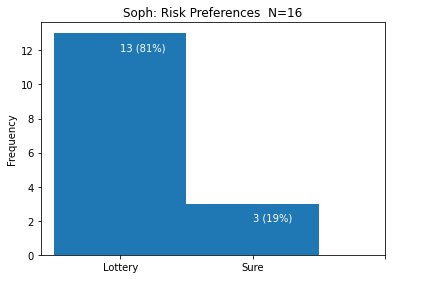

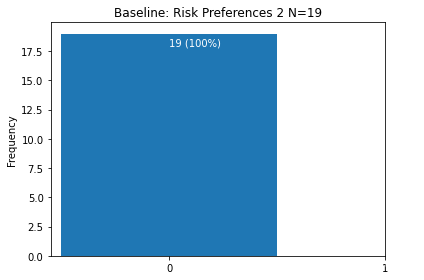

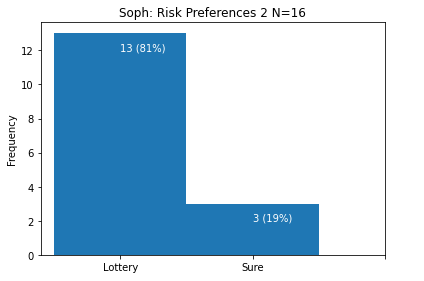

In [56]:
for s in ['','2']:
    fig, ax = plt.subplots()
    y = [int(i)-1 for i in  base[f'inference.1.player.lottery{s}']]
    xLabels = ['Lottery', 'Sure', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for i in range(max(y)+2):
        plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
    try:
        plt.xticks(x, xLabels)
    except:
        pass
    plt.title(f'Baseline: Risk Preferences {s} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'base_lottery{s}.png',dpi=1000)
    plt.show()

    fig, ax = plt.subplots()
    y = [int(i)-1 for i in  soph[f'inference.1.player.lottery{s}']]
    xLabels = ['Lottery', 'Sure', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for i in range(max(y)+2):
        plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
    try:
        plt.xticks(x, xLabels)
    except:
        pass
    plt.title(f'Soph: Risk Preferences {s} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'soph_lottery{s}.png',dpi=1000)
    plt.show()

In [57]:
# print(round(base.groupby(['inference.1.player.lottery']).count()['inference.1.player.taskDifficulty'],2),soph.groupby(['inference.1.player.lottery']).count()['inference.1.player.taskDifficulty'],2)
print(soph[soph['inference.1.player.lottery']==1].groupby(soph['inference.1.player.taskDifficulty']).count()['inference.1.player.taskDifficulty'])

inference.1.player.taskDifficulty
1.0    4
2.0    9
Name: inference.1.player.taskDifficulty, dtype: int64


In [58]:
soph['inference.1.player.taskDifficulty']

9     2.0
13    1.0
16    1.0
17    2.0
23    1.0
24    2.0
25    2.0
45    1.0
49    1.0
51    1.0
53    2.0
54    2.0
55    2.0
57    2.0
60    2.0
62    2.0
Name: inference.1.player.taskDifficulty, dtype: float64

In [59]:
print(base[['inference.1.player.taskDifficulty2','inference.1.player.taskDifficulty_stage2','inference.1.player.lottery','inference.1.player.lottery2']])

    inference.1.player.taskDifficulty2  \
4                                  2.0   
7                                  1.0   
8                                  2.0   
10                                 2.0   
12                                 2.0   
15                                 1.0   
18                                 2.0   
19                                 2.0   
21                                 2.0   
22                                 1.0   
46                                 2.0   
48                                 1.0   
50                                 2.0   
52                                 1.0   
61                                 2.0   
64                                 2.0   
65                                 1.0   
66                                 2.0   
67                                 1.0   

    inference.1.player.taskDifficulty_stage2  inference.1.player.lottery  \
4                                        2.0                         2.0   
7      

## Learning

#### Sophisticated

In [60]:
for num in range(1,5):
    soph[f'mistake{num}'] = np.NaN
for ind in soph[soph['inference.1.player.lottery']==1].index:
    if soph['inference.1.player.taskDifficulty'][ind] == 1:
        soph['mistake1'][ind] = 1
    else:
        soph['mistake1'][ind] = 0
    if soph['inference.1.player.taskDifficulty2'][ind] == 1:
        soph['mistake3'][ind] = 1
    else:
        soph['mistake3'][ind] = 0
for ind in soph[soph['inference.1.player.lottery2']==1].index:
    if soph['inference.1.player.taskDifficulty_stage2'][ind] == 1:
        soph['mistake2'][ind] = 1
    else:
        soph['mistake2'][ind] = 0
    if soph['inference.1.player.taskDifficulty2_stage2'][ind] == 1:
        soph['mistake4'][ind] = 1
    else:
        soph['mistake4'][ind] = 0
print(soph[['mistake1','mistake2','mistake3','mistake4']],'\n NaN is subjects who picked sure payment')

soph['mistakes']=soph['mistake1']+soph['mistake2']+soph['mistake3']+soph['mistake4']
soph['mistakes']

    mistake1  mistake2  mistake3  mistake4
9        0.0       0.0       1.0       0.0
13       1.0       0.0       1.0       0.0
16       1.0       1.0       1.0       1.0
17       0.0       0.0       0.0       0.0
23       1.0       1.0       1.0       1.0
24       0.0       0.0       0.0       1.0
25       0.0       0.0       0.0       0.0
45       NaN       NaN       NaN       NaN
49       NaN       NaN       NaN       NaN
51       1.0       1.0       1.0       0.0
53       NaN       NaN       NaN       NaN
54       0.0       0.0       0.0       0.0
55       0.0       1.0       0.0       0.0
57       0.0       0.0       0.0       0.0
60       0.0       0.0       0.0       0.0
62       0.0       0.0       0.0       0.0 
 NaN is subjects who picked sure payment


9     1.0
13    2.0
16    4.0
17    0.0
23    4.0
24    1.0
25    0.0
45    NaN
49    NaN
51    3.0
53    NaN
54    0.0
55    1.0
57    0.0
60    0.0
62    0.0
Name: mistakes, dtype: float64

In [61]:
for num in range(1,5):
    print(soph[f'mistake{num}'].mean())

0.3076923076923077
0.3076923076923077
0.38461538461538464
0.23076923076923078


In [62]:
for num in range(1,5):
    soph[f'mistake{num}'] = np.NaN
for ind in soph[soph['inference.1.player.lottery']==2].index:
    if soph['inference.1.player.taskDifficulty'][ind] == 2:
        soph['mistake1'][ind] = 1
    else:
        soph['mistake1'][ind] = 0
    if soph['inference.1.player.taskDifficulty2'][ind] == 2:
        soph['mistake3'][ind] = 1
    else:
        soph['mistake3'][ind] = 0
for ind in soph[soph['inference.1.player.lottery2']==2].index:
    if soph['inference.1.player.taskDifficulty_stage2'][ind] == 2:
        soph['mistake2'][ind] = 1
    else:
        soph['mistake2'][ind] = 0
    if soph['inference.1.player.taskDifficulty2_stage2'][ind] == 2:
        soph['mistake4'][ind] = 1
    else:
        soph['mistake4'][ind] = 0
print(soph[['mistake1','mistake2','mistake3','mistake4']],'\n NaN is subjects who picked lottery')

soph['mistakes']=soph['mistake1']+soph['mistake2']+soph['mistake3']+soph['mistake4']
soph['mistakes']

    mistake1  mistake2  mistake3  mistake4
9        NaN       NaN       NaN       NaN
13       NaN       NaN       NaN       NaN
16       NaN       NaN       NaN       NaN
17       NaN       NaN       NaN       NaN
23       NaN       NaN       NaN       NaN
24       NaN       NaN       NaN       NaN
25       NaN       NaN       NaN       NaN
45       0.0       0.0       1.0       0.0
49       0.0       1.0       0.0       0.0
51       NaN       NaN       NaN       NaN
53       1.0       1.0       1.0       0.0
54       NaN       NaN       NaN       NaN
55       NaN       NaN       NaN       NaN
57       NaN       NaN       NaN       NaN
60       NaN       NaN       NaN       NaN
62       NaN       NaN       NaN       NaN 
 NaN is subjects who picked lottery


9     NaN
13    NaN
16    NaN
17    NaN
23    NaN
24    NaN
25    NaN
45    1.0
49    1.0
51    NaN
53    3.0
54    NaN
55    NaN
57    NaN
60    NaN
62    NaN
Name: mistakes, dtype: float64

#### Baseline

In [63]:
for num in range(1,5):
    base[f'mistake{num}'] = np.NaN
for ind in base[base['inference.1.player.lottery']==1].index:
    if base['inference.1.player.taskDifficulty'][ind] == 1:
        base['mistake1'][ind] = 1
    else:
        base['mistake1'][ind] = 0
    if base['inference.1.player.taskDifficulty2'][ind] == 1:
        base['mistake3'][ind] = 1
    else:
        base['mistake3'][ind] = 0
for ind in base[base['inference.1.player.lottery2']==1].index:
    if base['inference.1.player.taskDifficulty_stage2'][ind] == 1:
        base['mistake2'][ind] = 1
    else:
        base['mistake2'][ind] = 0
    if base['inference.1.player.taskDifficulty2_stage2'][ind] == 1:
        base['mistake4'][ind] = 1
    else:
        base['mistake4'][ind] = 0
print(base[['mistake1','mistake2','mistake3','mistake4']],'\n NaN is subjects who picked sure payment')

base['mistakes']=base['mistake1']+base['mistake2']+base['mistake3']+base['mistake4']
base['mistakes']
for num in range(1,5):
    print(base[f'mistake{num}'].mean())

    mistake1  mistake2  mistake3  mistake4
4        NaN       0.0       NaN       0.0
7        1.0       1.0       1.0       1.0
8        1.0       0.0       0.0       0.0
10       0.0       0.0       0.0       0.0
12       0.0       0.0       0.0       0.0
15       1.0       1.0       1.0       1.0
18       NaN       1.0       NaN       1.0
19       0.0       0.0       0.0       0.0
21       0.0       0.0       0.0       0.0
22       0.0       1.0       1.0       1.0
46       1.0       1.0       0.0       0.0
48       1.0       1.0       1.0       1.0
50       1.0       0.0       0.0       0.0
52       1.0       1.0       1.0       1.0
61       0.0       1.0       0.0       1.0
64       0.0       0.0       0.0       0.0
65       1.0       1.0       1.0       1.0
66       0.0       0.0       0.0       0.0
67       1.0       0.0       1.0       0.0 
 NaN is subjects who picked sure payment
0.5294117647058824
0.47368421052631576
0.4117647058823529
0.42105263157894735


### Advice

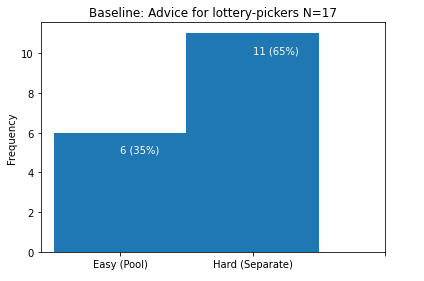

In [64]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  base[base['inference.1.player.lottery']==1]['inference.1.player.advice']]
xLabels = ['Easy (Pool)', 'Hard (Separate)', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Baseline: Advice for lottery-pickers N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + 'Baseline_advice.png',dpi=1000)
plt.show()

In [65]:
baseLot = base[base['inference.1.player.lottery']==1]
base1 = baseLot[baseLot['inference.1.player.taskDifficulty']==1].groupby(['inference.1.player.advice'])['inference.1.player.taskDifficulty'].count()
base2 = baseLot[baseLot['inference.1.player.taskDifficulty']==2].groupby(['inference.1.player.advice'])['inference.1.player.taskDifficulty'].count()
print('Did not reveal in first half: ', base1, '\n Revealed in first half: ', base2)

Did not reveal in first half:  inference.1.player.advice
1.0    6
2.0    3
Name: inference.1.player.taskDifficulty, dtype: int64 
 Revealed in first half:  inference.1.player.advice
2.0    8
Name: inference.1.player.taskDifficulty, dtype: int64


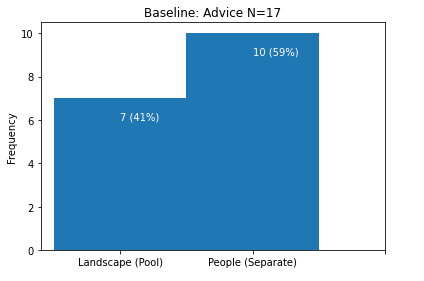

In [66]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  base[base['inference.1.player.lottery']==1]['inference.1.player.advice2']]
xLabels = ['Landscape (Pool)', 'People (Separate)', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Baseline: Advice N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath +  'Baseline_advice2.png',dpi=1000)
plt.show()

### Part 2: Bonus Choice - Do people know what to do with the information?

In [67]:
baseLot = base[base['inference.1.player.lottery']==1]
sophLot = soph[soph['inference.1.player.lottery']==1]

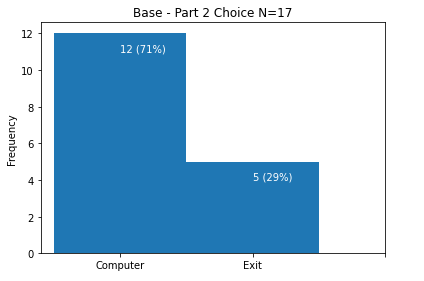

In [68]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  baseLot['inference.1.player.bonusChoice']]
xLabels = ['Computer', 'Exit', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

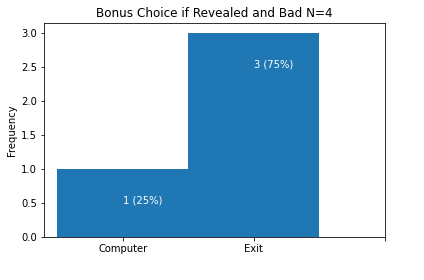

In [69]:
easyData = baseLot[(baseLot['observedTaskDifficulty']==2)]
var = easyData[baseLot['inference.1.player.compType']==0]['inference.1.player.bonusChoice']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
fig, ax = plt.subplots()
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Bonus Choice if Revealed and Bad N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'RevealedBad.png',dpi=1000)
plt.show()

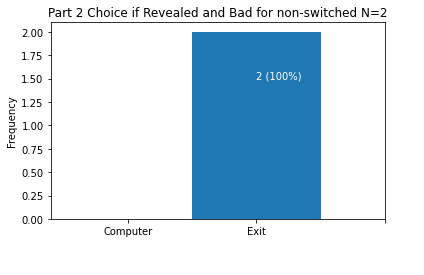

In [70]:
hardData = baseLot[(baseLot['observedTaskDifficulty']==2)]
hardData = hardData[hardData['inference.1.player.taskDifficulty']==2]
var = hardData[baseLot['inference.1.player.compType']==0]['inference.1.player.bonusChoice']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
fig, ax = plt.subplots()
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Part 2 Choice if Revealed and Bad for non-switched N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'RevealedBadNonSwitched.png',dpi=1000)
plt.show()

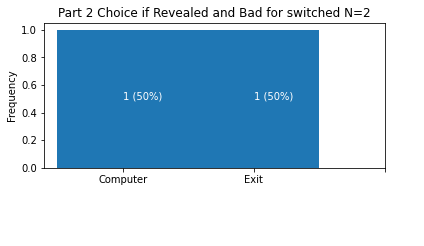

In [71]:
hardData = baseLot[(baseLot['observedTaskDifficulty']==2)]
hardData = hardData[hardData['inference.1.player.taskDifficulty']==1]
var = hardData[baseLot['inference.1.player.compType']==0]['inference.1.player.bonusChoice']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
fig, ax = plt.subplots()
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Part 2 Choice if Revealed and Bad for switched N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'RevealedBadSwitched.png',dpi=1000)
plt.show()

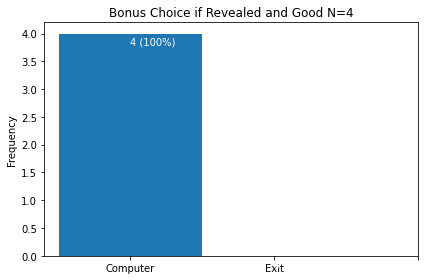

In [72]:
fig, ax = plt.subplots()
hardData = baseLot[baseLot['observedTaskDifficulty']==2]
var = hardData[baseLot['inference.1.player.compType']==1]['inference.1.player.bonusChoice']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.2,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Bonus Choice if Revealed and Good N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'RevealedGood.png',dpi=1000)
plt.show()

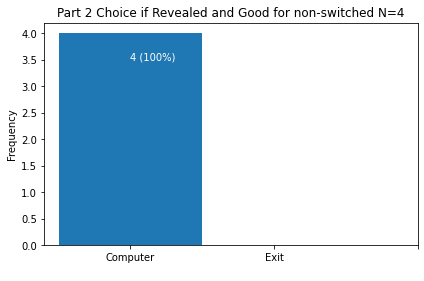

In [73]:
hardData = baseLot[(baseLot['observedTaskDifficulty']==2)]
hardData = hardData[hardData['inference.1.player.taskDifficulty']==2]
var = hardData[baseLot['inference.1.player.compType']==1]['inference.1.player.bonusChoice']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
fig, ax = plt.subplots()
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Part 2 Choice if Revealed and Good for non-switched N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'RevealedGoodNonSwitched.png',dpi=1000)
plt.show()

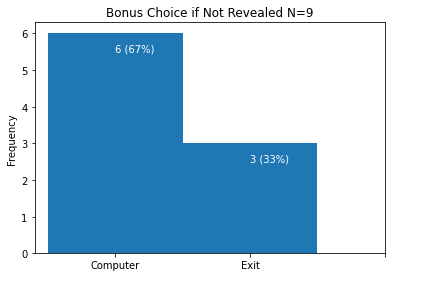

In [74]:
fig, ax = plt.subplots()
var = baseLot[baseLot['observedTaskDifficulty2']==1]['inference.1.player.bonusChoice']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Bonus Choice if Not Revealed N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'NotRevealed.png',dpi=1000)
plt.show()

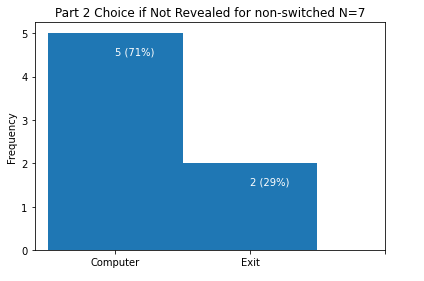

In [75]:
easyData = baseLot[(baseLot['observedTaskDifficulty']==1)]
easyData = easyData[easyData['inference.1.player.taskDifficulty']==1]
var = easyData['inference.1.player.bonusChoice']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
fig, ax = plt.subplots()
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Part 2 Choice if Not Revealed for non-switched N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'NotRevealedNonSwitched.png',dpi=1000)
plt.show()

### Bonus Choice For Sophs

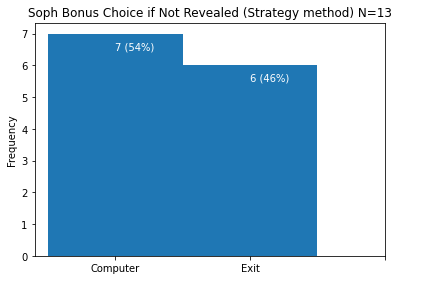

In [76]:
var = sophLot['inference.1.player.bonusChoiceEasy']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
fig, ax = plt.subplots()
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Soph Bonus Choice if Not Revealed (Strategy method) N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'Soph_NotRevealed.png',dpi=1000)
plt.show()

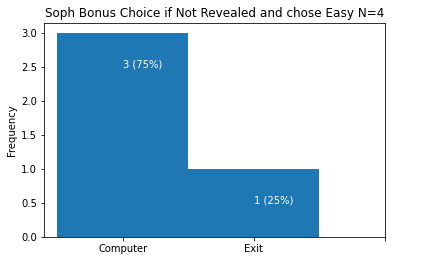

In [77]:
var = sophLot[sophLot['inference.1.player.taskDifficulty']==1]['inference.1.player.bonusChoiceEasy']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
fig, ax = plt.subplots()
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Soph Bonus Choice if Not Revealed and chose Easy N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'Soph_NotRevealed_easyPickers.png',dpi=1000)
plt.show()

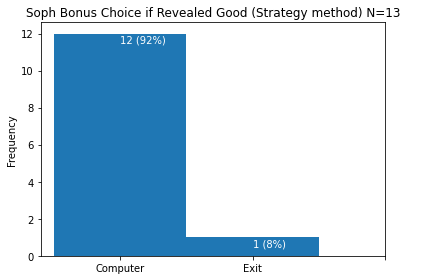

In [133]:
var = sophLot['inference.1.player.bonusChoiceHardGood']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
fig, ax = plt.subplots()
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Soph Bonus Choice if Revealed Good (Strategy method) N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'Soph_RevealedGood.png',dpi=1000)
plt.show()

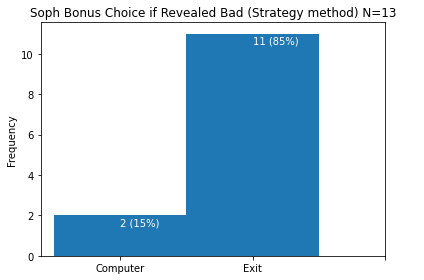

In [134]:
var = sophLot['inference.1.player.bonusChoiceHardBad']
y = [int(i)-1 for i in  var]
xLabels = ['Computer', 'Exit', '']
x = np.arange(len(xLabels))
fig, ax = plt.subplots()
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-0.5,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Soph Bonus Choice if Revealed Bad (Strategy method) N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + var.name[19:] +'Soph_RevealedBad.png',dpi=1000)
plt.show()

#### Risk Preferences

In [ ]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  base['inference.1.player.lottery']]
xLabels = ['Lottery', 'Sure', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Risk Preferences N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath + 'lottery.png',dpi=1000)
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  base[base['inference.1.player.taskDifficulty']==1]['inference.1.player.lottery']]
xLabels = ['Lottery', 'Sure', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Risk Preferences for those who choose no-revelation N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + 'lottery.png',dpi=1000)
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  base[base['inference.1.player.taskDifficulty']==2]['inference.1.player.lottery']]
xLabels = ['Lottery', 'Sure', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Risk Preferences for those who choose revelation N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + 'lottery.png',dpi=1000)
plt.show()

### Results conditional on lottery choice

In [ ]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  base[base['inference.1.player.lottery']==1]['inference.1.player.taskDifficulty']]
xLabels = ['Easy (Pool)', 'Hard (Separate)', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Baseline: Revelation Choice for lottery-pickers N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath +  'Baseline_taskDifficultyLottery.png',dpi=1000)
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  base[base['inference.1.player.lottery']==1]['inference.1.player.taskDifficulty2']]
xLabels = ['Landscape (Pool)', 'People (Separate)', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Baseline: Revelation Choice for lottery-pickers N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath +  'Baseline_taskDifficulty.png',dpi=1000)
plt.show()

#### For soph

In [ ]:
try:
    fig, ax = plt.subplots()
    y = [int(i)-1 for i in  soph['inference.1.player.lottery']]
    xLabels = ['Lottery', 'Sure', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for i in range(max(y)+2):
        plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Risk Preferences N={len(y)}')
    plt.tight_layout()
    # plt.savefig(outputpath + 'lottery.png',dpi=1000)
    plt.show()
except: 
    print('everyone chooses:', soph['inference.1.player.lottery'])

In [ ]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  soph[soph['inference.1.player.lottery']==1]['inference.1.player.taskDifficulty']]
xLabels = ['Easy (Pool)', 'Hard (Separate)', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Soph: Revelation Choice for lottery-pickers N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath +  'Soph_taskDifficultyLottery.png',dpi=1000)
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  soph[soph['inference.1.player.lottery']==1]['inference.1.player.taskDifficulty2']]
xLabels = ['Landscape (Pool)', 'People (Separate)', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Soph: Revelation Choice for lottery-pickers in round 2 N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath +  'Soph_taskDifficulty2Lottery.png',dpi=1000)
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = [int(i)-1 for i in  base[base['inference.1.player.lottery']==1]['inference.1.player.taskDifficulty2']]
xLabels = ['Landscape (Pool)', 'People (Separate)', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Baseline: Revelation Choice for lottery-pickers in round 2 N={len(y)}')
plt.tight_layout()
plt.savefig(outputpath +  'Baseline_taskDifficulty2Lottery.png',dpi=1000)
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)
print(soph[soph['inference.1.player.taskDifficulty']==1][['inference.1.player.lottery','inference.1.player.taskDifficulty', 'inference.1.player.taskDifficulty2','inference.1.player.explain']])

In [ ]:
pd.set_option('display.max_colwidth', None)
print(base[(base['inference.1.player.lottery']==1)][['inference.1.player.taskDifficulty', 'inference.1.player.explain']])

In [ ]:
pd.set_option('display.max_colwidth', None)
print(soph[(soph['inference.1.player.lottery']==1)][['inference.1.player.taskDifficulty', 'inference.1.player.explain']])

In [ ]:
pd.set_option('display.max_colwidth', None)
print(soph[soph['inference.1.player.taskDifficulty2']==2][['inference.1.player.lottery','inference.1.player.taskDifficulty2', 'inference.1.player.explain2']])

### Feedback

In [ ]:
for var in [data['inference.1.player.feedbackSatisfied'],data['inference.1.player.feedbackDifficulty'],data['inference.1.player.feedbackUnderstanding'],data['inference.1.player.feedbackPay']]:
    fig, ax = plt.subplots()
    y = [int(i) for i in var]
    xLabels = np.arange(11)
    x = np.arange(len(xLabels))
    ax.hist(y,x+0.5, width=1)
    plt.ylabel('Frequency')
    for i in range(max(y)+1):
        plt.text(i,y.count(i),str(y.count(i)))
    plt.xticks(x, xLabels)
    plt.title(f'{var.name[27:]} N={len(y)} ; 10 is most')
    plt.tight_layout()
    plt.savefig(outputpath + var.name[27:] +'.png',dpi=1000)
    plt.show()

## Learning

In [ ]:
print(data.loc[(data[f'final_WTP_{env}_D3']>0) & (data[f'final_WTP_{env1}_D3']>0)][f'final_WTP_{env1}_D3'])